In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


/kaggle/input/playground-series-s3e14/sample_submission.csv
/kaggle/input/playground-series-s3e14/train.csv
/kaggle/input/playground-series-s3e14/test.csv


In [2]:
#Data Wrangling
def wrangle(filepath):
    df=pd.read_csv(filepath)
    df.set_index('id',inplace=True)
    
    #droppin duplicate values
    #df=df.drop_duplicates()
    
    # calculate the IQR for each selected column
    Q1 = df.quantile(0.25)
    Q3 = df.quantile(0.75)
    IQR = Q3 - Q1

# define the range of acceptable values for each selected column
    range_min = Q1 - 1.5 * IQR
    range_max = Q3 + 1.5 * IQR

# replace outliers with 0.25 quantile value for that column
    for col in df.columns:
        df.loc[df[col] < range_min[col], col] = df[col].quantile(0.25)
    low_corr_cols= ['honeybee','bumbles','andrena','osmia','MaxOfUpperTRange','MinOfUpperTRange','AverageOfUpperTRange','MaxOfLowerTRange','MinOfLowerTRange','AverageOfLowerTRange']
    df.drop(columns=low_corr_cols,inplace=True)
    return(df)

In [3]:
df=wrangle('/kaggle/input/playground-series-s3e14/train.csv')

In [4]:
# Calculate the correlation coefficients with respect to 'yield'
corr_matrix = df.corr()['yield']

    # Remove columns with correlation coefficient less than 0.5 with respect to 'yield'
low_corr_columns = corr_matrix[abs(corr_matrix) < 0.3].index.tolist()
low_corr_columns

[]

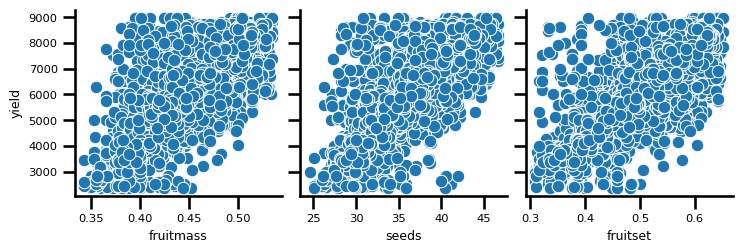

In [5]:
sns.set_context('talk', font_scale=0.5)
sns.pairplot(df,kind='scatter',y_vars='yield',x_vars=['fruitmass','seeds','fruitset'])

<AxesSubplot: xlabel='yield', ylabel='Count'>

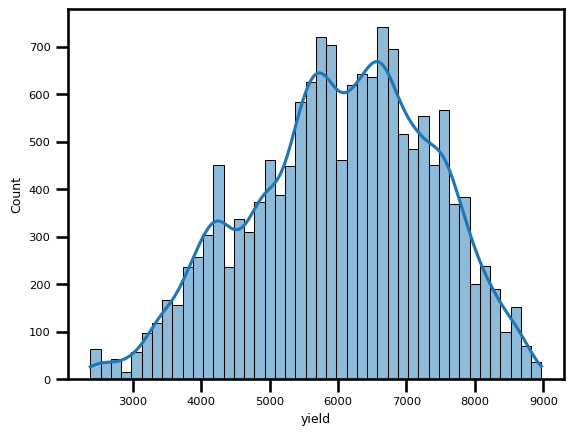

In [6]:
sns.histplot(data=df,x='yield',kde=True)

In [7]:
# DEfining independent and target variable
X=df.drop(columns='yield')
y=df[['yield']]

In [8]:
from sklearn.preprocessing import StandardScaler
# Scale the data using StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [9]:
from sklearn.model_selection import train_test_split
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Print the shapes of the resulting arrays
print('X_train shape:', X_train.shape)
print('y_train shape:', y_train.shape)
print('X_test shape:', X_test.shape)
print('y_test shape:', y_test.shape)


X_train shape: (12231, 6)
y_train shape: (12231, 1)
X_test shape: (3058, 6)
y_test shape: (3058, 1)


In [10]:
models = pd.DataFrame(columns=["Model","MAE","MSE","RMSE","R2 Score","RMSE (Cross-Validation)"])

In [11]:
#Calculating RMSE,SSE,MAE
models = pd.DataFrame(columns=["Model","MAE","MSE","RMSE","R2 Score","RMSE (Cross-Validation)"])
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
def evaluation(y, predictions):
    mae = mean_absolute_error(y, predictions)
    mse = mean_squared_error(y, predictions)
    rmse = np.sqrt(mean_squared_error(y, predictions))
    r_squared = r2_score(y, predictions)
    return mae, mse, rmse, r_squared
def rmse_cv(model):
    rmse = np.sqrt(-cross_val_score(model, X, y, scoring="neg_mean_squared_error", cv=5)).mean()
    return rmse

In [12]:
#applying linear regression model
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
model=LinearRegression()
model.fit(X_train,y_train)
test_y_pred=model.predict(X_test)
mae,mse,rmse,r_squared=evaluation(y_test,test_y_pred)
print("MAE:", mae)
print("MSE:", mse)
print("RMSE:", rmse)
print("R2 Score:", r_squared)
rmse_cross_val = rmse_cv(model)
print("RMSE Cross-Validation:", rmse_cross_val)

new_row = {"Model": "Linear","MAE": mae, "MSE": mse, "RMSE": rmse, "R2 Score": r_squared, "RMSE (Cross-Validation)": rmse_cross_val}
models = models.append(new_row,ignore_index=True)

MAE: 381.5203621233626
MSE: 351580.64454659645
RMSE: 592.9423619093145
R2 Score: 0.7964291762297251
RMSE Cross-Validation: 599.3052697926223


/tmp/ipykernel_34/972863787.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  models = models.append(new_row,ignore_index=True)


In [13]:
#applying random forest
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
rf=RandomForestRegressor()
rf.fit(X_train,y_train)
y_predict = rf.predict(X_test)
mae,mse,rmse,r_squared=evaluation(y_test,y_predict)
print("MAE:", mae)
print("MSE:", mse)
print("RMSE:", rmse)
print("R2 Score:", r_squared)
rmse_cross_val = rmse_cv(rf)
print("RMSE Cross-Validation:", rmse_cross_val)

new_row = {"Model": "Random Forest","MAE": mae, "MSE": mse, "RMSE": rmse, "R2 Score": r_squared, "RMSE (Cross-Validation)": rmse_cross_val}
models = models.append(new_row, ignore_index=True)

/tmp/ipykernel_34/236599137.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(X_train,y_train)


MAE: 368.06090861560546
MSE: 331455.18495504465
RMSE: 575.7214473641264
R2 Score: 0.8080821396432573


/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed whe

RMSE Cross-Validation: 583.8832103427924


/tmp/ipykernel_34/236599137.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  models = models.append(new_row, ignore_index=True)


In [14]:
#applying Ridge Regression
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score
rg=Ridge()
rg.fit(X_train,y_train)
y_pred=rg.predict(X_test)
mae,mse,rmse,r_squared=evaluation(y_test,y_pred)
print("MAE:", mae)
print("MSE:", mse)
print("RMSE:", rmse)
print("R2 Score:", r_squared)
rmse_cross_val = rmse_cv(rg)
print("RMSE Cross-Validation:", rmse_cross_val)

new_row = {"Model": "Ridge","MAE": mae, "MSE": mse, "RMSE": rmse, "R2 Score": r_squared, "RMSE (Cross-Validation)": rmse_cross_val}
models = models.append(new_row, ignore_index=True)

MAE: 381.54165666506526
MSE: 351586.11107764934
RMSE: 592.9469715561834
R2 Score: 0.7964260110206987
RMSE Cross-Validation: 600.4836217863204


/tmp/ipykernel_34/1489586281.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  models = models.append(new_row, ignore_index=True)


In [15]:
#applying Lasso Regression
from sklearn.linear_model import Lasso
from sklearn.model_selection import cross_val_score
ls=Lasso()
ls.fit(X_train,y_train)
pred_y=ls.predict(X_test)
mae,mse,rmse,r_squared=evaluation(y_test,pred_y)
print("MAE:", mae)
print("MSE:", mse)
print("RMSE:", rmse)
print("R2 Score:", r_squared)
rmse_cross_val = rmse_cv(ls)
print("RMSE Cross-Validation:", rmse_cross_val)

new_row = {"Model": "Lasso","MAE": mae, "MSE": mse, "RMSE": rmse, "R2 Score": r_squared, "RMSE (Cross-Validation)": rmse_cross_val}
models = models.append(new_row, ignore_index=True)

MAE: 381.90925676835747
MSE: 351735.3391784267
RMSE: 593.072794164786
R2 Score: 0.7963396055604547
RMSE Cross-Validation: 602.9819763807349


/tmp/ipykernel_34/4177284257.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  models = models.append(new_row, ignore_index=True)


In [16]:
#applying Elasticnet Regression
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import cross_val_score
en=ElasticNet()
en.fit(X_train,y_train)
predicted_y=en.predict(X_test)
mae,mse,rmse,r_squared=evaluation(y_test,predicted_y)
print("MAE:", mae)
print("MSE:", mse)
print("RMSE:", rmse)
print("R2 Score:", r_squared)
rmse_cross_val = rmse_cv(en)
print("RMSE Cross-Validation:", rmse_cross_val)

new_row = {"Model": "ElasticNet","MAE": mae, "MSE": mse, "RMSE": rmse, "R2 Score": r_squared, "RMSE (Cross-Validation)": rmse_cross_val}
models = models.append(new_row, ignore_index=True)

MAE: 454.50135750557416
MSE: 409772.6872648228
RMSE: 640.1348977089303
R2 Score: 0.7627350515480282
RMSE Cross-Validation: 644.9320651555261


/tmp/ipykernel_34/4206255584.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  models = models.append(new_row, ignore_index=True)


In [17]:
# applying XGBoost
import xgboost
from sklearn.model_selection import cross_val_score

# Create an XGBRegressor object
xgb = xgboost.XGBRegressor()

xgb.fit(X_train,y_train)
predict_y=xgb.predict(X_test)
mae,mse,rmse,r_squared=evaluation(y_test,predict_y)
print("MAE:", mae)
print("MSE:", mse)
print("RMSE:", rmse)
print("R2 Score:", r_squared)
rmse_cross_val = rmse_cv(xgb)
print("RMSE Cross-Validation:", rmse_cross_val)
print("RMSE Cross-Validation:", rmse_cross_val)

new_row = {"Model": "XGB regressor","MAE": mae, "MSE": mse, "RMSE": rmse, "R2 Score": r_squared, "RMSE (Cross-Validation)": rmse_cross_val}
models = models.append(new_row, ignore_index=True)

MAE: 364.23860577864417
MSE: 323950.9733469503
RMSE: 569.1669116761359
R2 Score: 0.8124271983445868
RMSE Cross-Validation: 578.7918679437723
RMSE Cross-Validation: 578.7918679437723


/tmp/ipykernel_34/1910420948.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  models = models.append(new_row, ignore_index=True)


In [18]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import cross_val_score

#polynomial REgression
poly_reg = PolynomialFeatures(degree=2)
x_poly=poly_reg.fit_transform(X_train)
X_test_2d = poly_reg.transform(X_test)
lin_reg = LinearRegression()
lin_reg.fit(x_poly, y_train)
predictions = lin_reg.predict(X_test_2d)
mae,mse,rmse,r_squared=evaluation(y_test,predictions)
print("MAE:", mae)
print("MSE:", mse)
print("RMSE:", rmse)
print("R2 Score:", r_squared)
rmse_cross_val = rmse_cv(lin_reg)
print("RMSE Cross-Validation:", rmse_cross_val)

new_row = {"Model": "Polynomial Regression (degree=2)","MAE": mae, "MSE": mse, "RMSE": rmse, "R2 Score": r_squared, "RMSE (Cross-Validation)": rmse_cross_val}
models = models.append(new_row, ignore_index=True)

MAE: 385.3891803810286
MSE: 362968.28821055125
RMSE: 602.4684956166183
R2 Score: 0.7898355481747358
RMSE Cross-Validation: 599.3052697926223


/tmp/ipykernel_34/797074798.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  models = models.append(new_row, ignore_index=True)


In [19]:
models.sort_values(by="RMSE (Cross-Validation)")

,Model,MAE,MSE,RMSE,R2 Score,RMSE (Cross-Validation)
5,XGB regressor,364.238606,323950.973347,569.166912,0.812427,578.791868
1,Random Forest,368.060909,331455.184955,575.721447,0.808082,583.883210
0,Linear,381.520362,351580.644547,592.942362,0.796429,599.305270
6,Polynomial Regression (degree=2),385.389180,362968.288211,602.468496,0.789836,599.305270
2,Ridge,381.541657,351586.111078,592.946972,0.796426,600.483622
3,Lasso,381.909257,351735.339178,593.072794,0.796340,602.981976
4,ElasticNet,454.501358,409772.687265,640.134898,0.762735,644.932065


**We will apply XGB regressor here**

In [20]:
df2=pd.read_csv('/kaggle/input/playground-series-s3e14/test.csv')
df2

,id,clonesize,honeybee,bumbles,andrena,osmia,MaxOfUpperTRange,MinOfUpperTRange,AverageOfUpperTRange,MaxOfLowerTRange,MinOfLowerTRange,AverageOfLowerTRange,RainingDays,AverageRainingDays,fruitset,fruitmass,seeds
0,15289,25.0,0.25,0.25,0.25,0.25,86.0,52.0,71.9,62.0,30.0,50.8,24.0,0.39,0.399367,0.408088,31.394569
1,15290,12.5,0.25,0.25,0.75,0.63,94.6,57.2,79.0,68.2,33.0,55.9,1.0,0.10,0.488048,0.442866,36.846956
2,15291,12.5,0.25,0.25,0.63,0.63,86.0,52.0,71.9,62.0,30.0,50.8,16.0,0.26,0.583379,0.487057,40.037644
3,15292,25.0,0.50,0.38,0.38,0.63,86.0,52.0,71.9,62.0,30.0,50.8,16.0,0.26,0.433014,0.422847,33.116091
4,15293,37.5,0.75,0.25,0.25,0.25,94.6,57.2,79.0,68.2,33.0,55.9,24.0,0.39,0.360996,0.388860,29.558019
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10189,25478,25.0,0.25,0.25,0.25,0.25,86.0,52.0,71.9,62.0,30.0,50.8,24.0,0.39,0.474162,0.437923,34.525258
10190,25479,25.0,0.50,0.25,0.50,0.75,77.4,46.8,64.7,55.8,27.0,45.8,16.0,0.26,0.482854,0.440676,35.648221
10191,25480,25.0,0.50,0.38,0.50,0.50,77.4,46.8,64.7,55.8,27.0,45.8,16.0,0.26,0.568854,0.463065,37.724724
10192,25481,12.5,0.25,0.25,0.38,0.50,94.6,57.2,79.0,68.2,33.0,55.9,34.0,0.56,0.407374,0.409261,31.881847


In [21]:
df1=wrangle('/kaggle/input/playground-series-s3e14/test.csv')

In [22]:
df1

,clonesize,RainingDays,AverageRainingDays,fruitset,fruitmass,seeds
id,,,,,,
15289,25.0,24.0,0.39,0.399367,0.408088,31.394569
15290,12.5,16.0,0.10,0.488048,0.442866,36.846956
15291,12.5,16.0,0.26,0.583379,0.487057,40.037644
15292,25.0,16.0,0.26,0.433014,0.422847,33.116091
15293,37.5,24.0,0.39,0.360996,0.388860,29.558019
...,...,...,...,...,...,...
25478,25.0,24.0,0.39,0.474162,0.437923,34.525258
25479,25.0,16.0,0.26,0.482854,0.440676,35.648221
25480,25.0,16.0,0.26,0.568854,0.463065,37.724724


In [23]:
from sklearn.preprocessing import StandardScaler
# Scale the data using StandardScaler
scaler = StandardScaler()
test_scaled = scaler.fit_transform(df1)

In [24]:
# applying XGBoost
import xgboost
from sklearn.model_selection import cross_val_score

# Create an XGBRegressor object
xgb = xgboost.XGBRegressor()

xgb.fit(X_train,y_train)
predictions=xgb.predict(test_scaled)
df1['yield']=predictions


In [25]:
df1.drop(columns=['clonesize','RainingDays','AverageRainingDays','fruitset','fruitmass','seeds'],inplace=True)

In [27]:
df1 = df1.reset_index()
df1

,index,id,yield
0,0,15289,4295.771484
1,1,15290,6241.846680
2,2,15291,7142.675781
3,3,15292,4688.237305
4,4,15293,3718.129395
...,...,...,...
10189,10189,25478,5466.272949
10190,10190,25479,5729.824219
10191,10191,25480,6448.318359
10192,10192,25481,4369.050781


In [28]:
df1.drop(columns=['index'],inplace=True)

In [29]:
df1

,id,yield
0,15289,4295.771484
1,15290,6241.846680
2,15291,7142.675781
3,15292,4688.237305
4,15293,3718.129395
...,...,...
10189,25478,5466.272949
10190,25479,5729.824219
10191,25480,6448.318359
10192,25481,4369.050781


In [30]:
df1.to_csv('submission.csv')